# ROC (Reciever-Operating Characteristic) Analysis

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import numpy as np
from scipy.stats import norm
import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.model_selection import cross_val_score, train_test_split, cross_val_predict
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
plt.rcParams.update({'font.size':16,'figure.figsize':(12,8)})

In [2]:
def animated_roc():
    fig_anim,ax = plt.subplots(1,2,figsize=(10,4))
    feature = np.linspace(5,33,1000)
    sick = norm.pdf(feature,23,3)
    healthy = norm.pdf(feature,15,3)
    ax[0].plot(feature,healthy,label='Healthy')
    ax[0].plot(feature,sick,label='Sick')
    line = ax[0].plot([5,5],[0,0.15],'--')[0]
    ax[0].set_xlabel('Feature Value')
    ax[0].set_ylabel('Probability Density')
    ax[0].legend(loc=1, fontsize=10)
    tpr = 1
    fpr = 1
    scat = ax[1].scatter([],[],s=50,color='red')
    ax[1].set_xlabel('False Positive Rate')
    ax[1].set_ylabel('True Positive Rate')
    ax[1].set_xlim(-0.02,1.02)
    ax[1].set_ylim(-0.02,1.02)
    plt.subplots_adjust(wspace=0.3)
    plt.tight_layout()
    thresholds = np.linspace(5,33,50)
    
    def update(threshold):
        fpr = 1-norm.cdf(threshold,15,3)
        tpr = 1-norm.cdf(threshold,23,3)
        line.set_xdata([threshold,threshold])
        history = ax[1].scatter([fpr],[tpr],s=10,color='black')
        scat.set_offsets([fpr,tpr])

    return fig_anim,update,thresholds

<IPython.core.display.Javascript object>


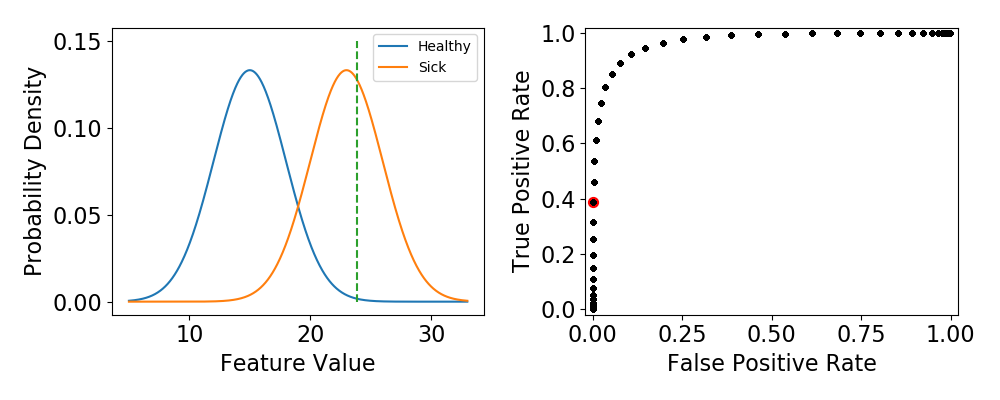

In [3]:
fig_anim,update,thresholds = animated_roc()
anim = FuncAnimation(fig_anim,update,thresholds)

In [4]:
# Create instance of these classes
rfc = RandomForestClassifier(oob_score=True)

# Load some data

In [5]:
# The URL of my data file
url = 'https://raw.githubusercontent.com/rgerkin/neuro-data-analysis-course/master/data/article_ephys_metadata_curated.csv'

# Load into a dataframe, recognizing that these data values are separated in the file by tabs and not commas
df = pd.read_csv(url, delimiter='\t')

# Use the column named "Index" as the index.
df = df.set_index('Index')

## Let's establish what we want to predict (the target) and what we want to predict it with.  

In [6]:
target = 'NeuronName'

possible_predictors = ['PubYear', 'BrainRegion', 'Species', 'Strain', 'ElectrodeType', 'PrepType', 'JxnPotential', 
              'JxnOffset', 'RecTemp', 'AnimalAge', 'AnimalWeight', 'external_0_Mg', 'external_0_Ca', 
              'external_0_Na', 'external_0_Cl', 'external_0_K', 'external_0_pH', 'internal_0_Mg', 
              'internal_0_Ca', 'internal_0_Na', 'internal_0_Cl', 'internal_0_K', 'internal_0_pH', 
              'rin', 'rmp', 'apthr', 'apamp', 'aphw', 'tau', 'ahpamp', 'cap', 'apwidth', 'apfreq', 'rheo', 
              'ahpdur', 'sagratio', 'maxfreq', 'apriseslope', 'fahpamp', 'spontfreq', 'appeak', 'apriset', 
              'apdecayslope', 'apdelay', 'fislope', 'adratio', 'apamprest', 'sagamp', 'sahpamp', 
              'apdecayt', 'accres', 'adratioinv', 'adpamp', 'ahpamprest', 'mahpamp', 'fahpdur', 'ahpvolt', 
              'sahpdur', 'celldiam', 'adpctother', 'adpct', 'adpctminus', 'surfarea', 'mahpdur', 
              'adratiominus', 'adpctinv', 'adpdur', 'fahpvolt', 'mahpamprest', 'apamptrough', 
              'sahpamprest', 'fahpamprest', 'sahpvolt', 'mahpvolt']

## Now let's divide this list into things that correspond to real numbers vs things that correspond to categories

In [7]:
numerical_predictors = ['PubYear', 'RecTemp', 'rin', 'rmp', 'apthr', 'apamp', 'aphw', 'tau']
categorical_predictors = ['BrainRegion', 'Species', 'Strain', 'ElectrodeType', 'PrepType']

df_predictors = df[numerical_predictors + categorical_predictors]
df_target = df[target]

In [8]:
df_predictors.head()

,PubYear,RecTemp,rin,rmp,apthr,apamp,aphw,tau,BrainRegion,Species,Strain,ElectrodeType,PrepType
Index,,,,,,,,,,,,,
150,2015,30.0,178.0,-72.2,NaN,NaN,0.38,7.9,Isocortex,Rats,"Rats, Wistar",Patch-clamp,in vitro
149,2015,30.0,361.0,-66.3,NaN,NaN,0.79,27.4,Isocortex,Rats,"Rats, Wistar",Patch-clamp,in vitro
151,2015,30.0,135.0,-68.0,NaN,NaN,0.20,8.0,Isocortex,Rats,"Rats, Wistar",Patch-clamp,in vitro
152,2015,30.0,83.0,-65.0,NaN,NaN,0.37,7.4,NaN,Rats,"Rats, Wistar",Patch-clamp,in vitro
88,2015,22.0,291.0,-64.3,-41.1,73.2,1.57,25.7,Isocortex,Macaca mulatta,Other,Patch-clamp,in vitro


## Let's handle the categorical fields (which usually, but not always, have text)

In [9]:
df_predictors = pd.get_dummies(df_predictors)
df_predictors.head()

,PubYear,RecTemp,rin,rmp,apthr,apamp,aphw,tau,BrainRegion_Cerebellum,BrainRegion_Cortical subplate,...,"ElectrodeType_Patch-clamp, Sharp",ElectrodeType_Perforated patch,"ElectrodeType_Perforated patch, Patch-clamp",ElectrodeType_Sharp,PrepType_Other,"PrepType_Other, in vitro",PrepType_cell culture,PrepType_in vitro,"PrepType_in vitro, cell culture",PrepType_in vivo
Index,,,,,,,,,,,,,,,,,,,,,
150,2015,30.0,178.0,-72.2,NaN,NaN,0.38,7.9,0,0,...,0,0,0,0,0,0,0,1,0,0
149,2015,30.0,361.0,-66.3,NaN,NaN,0.79,27.4,0,0,...,0,0,0,0,0,0,0,1,0,0
151,2015,30.0,135.0,-68.0,NaN,NaN,0.20,8.0,0,0,...,0,0,0,0,0,0,0,1,0,0
152,2015,30.0,83.0,-65.0,NaN,NaN,0.37,7.4,0,0,...,0,0,0,0,0,0,0,1,0,0
88,2015,22.0,291.0,-64.3,-41.1,73.2,1.57,25.7,0,0,...,0,0,0,0,0,0,0,1,0,0


## Let's also replace missing values with *something*, so that we run the algorithms

In [10]:
median_in_each_column = df_predictors.median()
df_predictors = df_predictors.fillna(median_in_each_column)
df_predictors.head()

,PubYear,RecTemp,rin,rmp,apthr,apamp,aphw,tau,BrainRegion_Cerebellum,BrainRegion_Cortical subplate,...,"ElectrodeType_Patch-clamp, Sharp",ElectrodeType_Perforated patch,"ElectrodeType_Perforated patch, Patch-clamp",ElectrodeType_Sharp,PrepType_Other,"PrepType_Other, in vitro",PrepType_cell culture,PrepType_in vitro,"PrepType_in vitro, cell culture",PrepType_in vivo
Index,,,,,,,,,,,,,,,,,,,,,
150,2015,30.0,178.0,-72.2,-41.8,72.0,0.38,7.9,0,0,...,0,0,0,0,0,0,0,1,0,0
149,2015,30.0,361.0,-66.3,-41.8,72.0,0.79,27.4,0,0,...,0,0,0,0,0,0,0,1,0,0
151,2015,30.0,135.0,-68.0,-41.8,72.0,0.20,8.0,0,0,...,0,0,0,0,0,0,0,1,0,0
152,2015,30.0,83.0,-65.0,-41.8,72.0,0.37,7.4,0,0,...,0,0,0,0,0,0,0,1,0,0
88,2015,22.0,291.0,-64.3,-41.1,73.2,1.57,25.7,0,0,...,0,0,0,0,0,0,0,1,0,0


## What about the target values (the cell types) that we want to predict? How many of each type are in the dataset?

In [11]:
df_target.value_counts().head(10)

Other                                 291
Neocortex pyramidal cell layer 5-6    123
Hippocampus CA1 pyramidal cell        116
Neocortex basket cell                  74
Neocortex pyramidal cell layer 2-3     71
Neocortex uncharacterized cell         49
Neostriatum medium spiny neuron        40
Neocortex Martinotti cell              37
Subiculum pyramidal cell               31
Neostriatum gabaergic interneuron      29
Name: NeuronName, dtype: int64

## For simplicity, let's restrict all of the data to only those cases that belong to one of these top-10 types

In [12]:
# Get the names of the top 10
top_10_cell_types = df_target.value_counts().head(10).index

# True or False, is the given row in that top 10 list?
is_in_top_10_cell_types = df_target.isin(top_10_cell_types)

# Extract only those values that are True (i.e. in the top-10) from both the predictors and the target
df_target = df_target[is_in_top_10_cell_types]
df_predictors = df_predictors[is_in_top_10_cell_types]

In [13]:
# Yes or No, is each neuron a 'Neocortex pyramidal cell layer 5-6' neuron?
y = (df_target == 'Neocortex pyramidal cell layer 5-6')

X = df_predictors

## Initialize the classification algorithm and fit the data

In [14]:
# Initialize the classification algorithm (Random Forest Classification) to use 100 decision trees
rfc = RandomForestClassifier(n_estimators=100)

In [15]:
# Fit this model 
rfc.fit(X, y);

## Computed on in-sample predictions

In [16]:
predicted_classes = rfc.predict_proba(X)
probabilities = pd.DataFrame(index=X.index, columns=['Non-Pyramidal', 'Pyramidal'], data=predicted_classes)
probabilities.head()

,Non-Pyramidal,Pyramidal
Index,,
150,0.985,0.015
149,0.980,0.020
151,0.980,0.020
88,0.920,0.080
89,0.940,0.060


In [17]:
fpr, tpr, thresholds = roc_curve(y, probabilities['Pyramidal'])

In [18]:
auc = roc_auc_score(y, probabilities['Pyramidal'])

In [19]:
plt.rcParams.update({'font.size':16,'figure.figsize':(8,6)})

In [20]:
def plot_roc(fpr,tpr):
    fig,ax = plt.subplots()
    ax.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
    ax.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC analysis')
    ax.legend(loc="lower right");

<IPython.core.display.Javascript object>


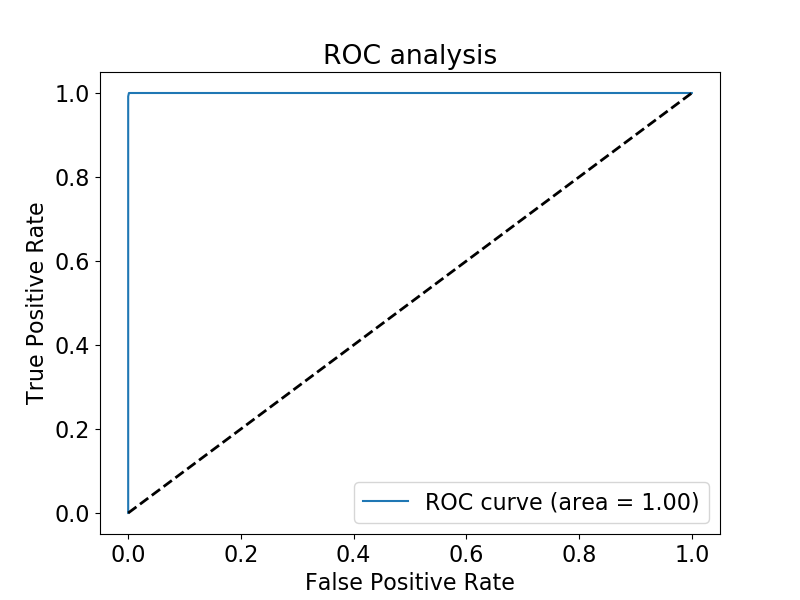

In [21]:
plot_roc(fpr,tpr)

## Computed on out-of-sample predictions

In [22]:
predicted_classes = cross_val_predict(rfc, X, y, method='predict_proba')
p = predicted_classes[:,1]
fpr, tpr, thresholds = roc_curve(y, p)
auc = roc_auc_score(y, p)

/home/rgerkin/.local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


<IPython.core.display.Javascript object>


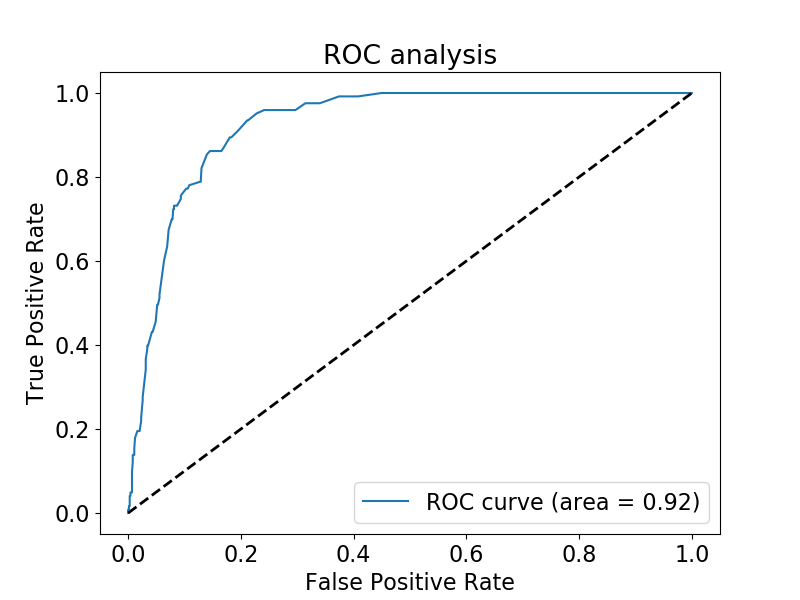

In [23]:
plot_roc(fpr,tpr)